# Chapter 7. 토픽 모델링으로 주제 찾기

## 7.2 사이킷런을 이용한 토픽 모델링

### 7.2.1 데이터 준비

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

#학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [2]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', 
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

In [5]:
review_cv.shape

(3219, 2000)

### 7.2.2 LDA 토픽 모델링 실행

#### 문서-토픽분포: (문서수,토픽수) lda.fit_transform().shape
#### 토픽-단어분포: (토픽수,단어수)  lda.components_.shape


In [6]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5, 
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', 
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)

print('#shape of topic word distribution:', lda.components_.shape)

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.903 0.007 0.027 0.008 0.007 0.008 0.007 0.007 0.007 0.018]
#Sum of topic weights of documents: [0.087 0.083 0.085 0.115 0.115 0.126 0.098 0.072 0.07  0.148]
#shape of topic word distribution: (10, 2000)


In [7]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda,cv.get_feature_names_out(), 10)

Topic #0: com, morality, keith, article, sgi, think, sandvik, objective, caltech, moral
Topic #1: image, file, graphics, files, ftp, available, software, use, data, mail
Topic #2: space, nasa, access, launch, earth, orbit, shuttle, digex, lunar, satellite
Topic #3: article, com, just, don't, like, i'm, nntp, university, host, posting
Topic #4: key, clipper, chip, encryption, com, government, law, keys, use, escrow
Topic #5: scsi, com, bit, ibm, bus, know, windows, thanks, card, university
Topic #6: host, gov, nntp, posting, university, distribution, nasa, ___, world, com
Topic #7: drive, com, disk, hard, controller, drives, dos, tape, floppy, problem
Topic #8: key, public, message, faq, mail, pgp, des, group, uni, ripem
Topic #9: god, people, don't, jesus, believe, just, does, say, think, know



### 2.3 최적의 토픽 수 선택하기
### - 가장 중요한 하이퍼파라미터 = "토픽 수"


n_components: 1, perplexity: 1330.357
n_components: 2, perplexity: 1248.848
n_components: 3, perplexity: 1108.628
n_components: 4, perplexity: 1061.697
n_components: 5, perplexity: 1053.574
n_components: 6, perplexity: 1058.260
n_components: 7, perplexity: 1055.111
n_components: 8, perplexity: 1018.328
n_components: 9, perplexity: 1017.749
n_components: 10, perplexity: 1028.686
n_components: 11, perplexity: 1033.398
n_components: 12, perplexity: 1032.112
n_components: 13, perplexity: 1038.642
n_components: 14, perplexity: 1038.627
n_components: 15, perplexity: 1044.712


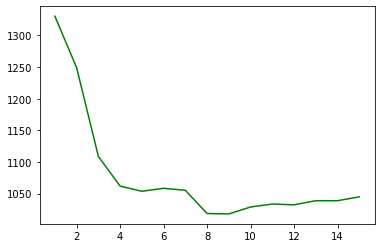

n_components with minimum perplexity: 9


In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:",
      show_perplexity(review_cv, start=1, end=15))

In [11]:
lda = LatentDirichletAllocation(n_components = 8, #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: image, graphics, available, file, mail, ftp, data, information, files, software
Topic #1: posting, nntp, host, com, university, gov, distribution, article, nasa, ___
Topic #2: com, keith, article, morality, think, caltech, sgi, don't, objective, posting
Topic #3: com, jesus, article, know, god, just, don't, people, good, sandvik
Topic #4: people, god, does, don't, think, say, believe, just, like, way
Topic #5: drive, scsi, card, com, disk, ide, controller, hard, bus, use
Topic #6: space, nasa, access, launch, moon, year, article, digex, just, earth
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



## 7.3 Gensim을 이용한 토픽 모델링


### 7.3.1 Gensim 사용법과 시각화

In [12]:
#!pip install --upgrade gensim

In [13]:
# 필요한 library들을 import
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

cachedStopWords = stopwords.words("english")

RegTok = RegexpTokenizer("[\w']{3,}") # 정규포현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english')) #영어 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower()) 
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data] # **이코드도 중요하다**

In [33]:
len(texts[1])
texts[0]

['livesey',
 'solntze',
 'wpd',
 'sgi',
 'com',
 'jon',
 'livesey',
 'subject',
 'moraltiy',
 'political',
 'atheists',
 'organization',
 'sgi',
 'lines',
 'nntp',
 'posting',
 'host',
 'solntze',
 'wpd',
 'sgi',
 'com',
 'article',
 '1ql8ekinn635',
 'gap',
 'caltech',
 'edu',
 'keith',
 'cco',
 'caltech',
 'edu',
 'keith',
 'allan',
 'schneider',
 'writes',
 'livesey',
 'solntze',
 'wpd',
 'sgi',
 'com',
 'jon',
 'livesey',
 'writes',
 'act',
 'morally',
 'particular',
 'reason',
 'moral',
 'morality',
 'instinctive',
 'animals',
 'saying',
 'morality',
 'instinctive',
 'animals',
 'attempt',
 'assume',
 'conclusion',
 'conclusion',
 'conclusion',
 'correct',
 'err',
 'behaviour',
 'instinctive',
 'animals',
 'natural',
 'moral',
 'system',
 'see',
 'disagreeing',
 'definition',
 'moral',
 'earlier',
 'said',
 'must',
 'conscious',
 'act',
 'definition',
 'instinctive',
 'behavior',
 'pattern',
 'could',
 'act',
 'morality',
 'trying',
 'apply',
 'human',
 'terms',
 'non',
 'humans',


In [19]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts] # **이코드가 중요한 코드임**
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 46466
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 3219


In [49]:
# doc2bow 
# https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=pica4star&logNo=221436151042

# dictionary[0]
corpus[1] # [(a,b), (c,d)] a(=20)로 변환된 단어는 b(2번)나왔고, c(54)로 변환된 단어는 d(1번)나왔음. 

[(20, 2),
 (54, 1),
 (72, 1),
 (100, 1),
 (102, 2),
 (103, 1),
 (104, 2),
 (105, 1),
 (106, 1),
 (107, 1),
 (108, 1),
 (109, 1),
 (110, 2),
 (111, 2),
 (112, 2),
 (113, 1),
 (114, 1)]

In [50]:
from gensim.models import LdaModel

num_topics = 10
passes = 5 # max_iter 이다.
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

Wall time: 10.2 s


In [52]:
model.print_topics(num_words=10)

[(0,
  '0.023*"com" + 0.018*"keith" + 0.016*"caltech" + 0.013*"sgi" + 0.013*"nntp" + 0.013*"posting" + 0.013*"host" + 0.012*"would" + 0.012*"system" + 0.011*"livesey"'),
 (1,
  '0.020*"morality" + 0.018*"objective" + 0.015*"one" + 0.015*"say" + 0.014*"uiuc" + 0.012*"frank" + 0.012*"values" + 0.010*"faq" + 0.010*"article" + 0.008*"cso"'),
 (2,
  '0.026*"com" + 0.025*"access" + 0.025*"posting" + 0.023*"host" + 0.023*"nntp" + 0.017*"digex" + 0.015*"article" + 0.013*"cwru" + 0.013*"___" + 0.013*"net"'),
 (3,
  '0.021*"university" + 0.017*"posting" + 0.015*"host" + 0.015*"nntp" + 0.013*"article" + 0.010*"com" + 0.009*"know" + 0.009*"i\'m" + 0.009*"would" + 0.009*"thanks"'),
 (4,
  '0.032*"com" + 0.015*"would" + 0.011*"article" + 0.010*"one" + 0.010*"get" + 0.009*"people" + 0.009*"ibm" + 0.008*"government" + 0.007*"good" + 0.007*"i\'m"'),
 (5,
  '0.025*"key" + 0.017*"encryption" + 0.014*"clipper" + 0.014*"chip" + 0.009*"keys" + 0.009*"use" + 0.008*"security" + 0.008*"government" + 0.008*"pub

In [54]:
# model.get_document_topics(corpus)
# -> 0번째 토픽에 72.5%, 8번째 토픽에 27% 
print("#topic distribution of the first document: ", model.get_document_topics(corpus)[0]) 
# [0]첫번째문서에 대해서 토픽분포 알아봄

#topic distribution of the first document:  [(0, 0.72578037), (8, 0.26993954)]


In [56]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

C:\Users\wousi\anaconda3\lib\site-packages\pandas\compat\numpy\__init__.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _nlv = LooseVersion(_np_version)
C:\Users\wousi\anaconda3\lib\site-packages\pandas\compat\numpy\__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p17 = _nlv < LooseVersion("1.17")
C:\Users\wousi\anaconda3\lib\site-packages\pandas\compat\numpy\__init__.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  np_version_under1p18 = _nlv < LooseVersion("1.18")
C:\Users\wousi\anaconda3\lib\site-packages\pandas\compat\numpy\__init__.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_under1p19 = _nlv < LooseVersion("1.19")
C:\Users\wousi\anaconda3\lib\site-packages\pandas\compat\numpy\__init__.py:14: DeprecationWarning: distutils Version 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.137200  0.040249       1        1  22.657969
5      0.065990  0.123619       2        1  14.524625
9      0.072133  0.092873       3        1  12.988911
7      0.138320  0.043608       4        1  11.023300
4     -0.021828  0.007494       5        1   9.295267
6      0.072783 -0.094710       6        1   9.117607
3      0.027374 -0.054948       7        1   8.488915
0     -0.040787 -0.129975       8        1   4.523756
2      0.005361 -0.091971       9        1   4.055049
1     -0.182145  0.063761      10        1   3.324601, topic_info=            Term         Freq        Total Category  logprob  loglift
538        space  1487.000000  1487.000000  Default  30.0000  30.0000
20           com  3751.000000  3751.000000  Default  29.0000  29.0000
834          key  1316.000000  1316.000000  Default  28.0000  28.0000
1551        scsi   741.000000   741.000000  Default  27.0000  27.0000
70       posting  1723.000000  1723.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
65        people    64.405824  1672.560779  Topic10  -5.1558   0.1469
789          sci    53.231014   309.459986  Topic10  -5.3463   1.6436
602   university    56.828508  1486.959952  Topic10  -5.2810   0.1394
294         time    55.733504  1187.678373  Topic10  -5.3004   0.3446
315       better    54.159868   564.529017  Topic10  -5.3290   1.0598

[592 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1359      1  0.006272      128
1359      2  0.068996      128
1359      3  0.037634      128
1359      4  0.878130      128
153       1  0.057461     1993
...     ...       ...      ...
343       8  0.022397    years
343       9  0.005599    years
343      10  0.121318    years
704       3  0.991375      zoo
705       3  0.983926  zoology

[2804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 10, 8, 5, 7, 4, 1, 3, 2])

### 7.3.2 혼란도와 토픽 응집도를 이용한 최적값 선택

In [57]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.7493528544065975


C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics: 6, perplexity: -7.035, coherence: -1.701
num_topics: 7, perplexity: -7.023, coherence: -1.735
num_topics: 8, perplexity: -7.023, coherence: -1.547
num_topics: 9, perplexity: -7.007, coherence: -1.891
num_topics: 10, perplexity: -6.996, coherence: -1.888
num_topics: 11, perplexity: -7.027, coherence: -2.164
num_topics: 12, perplexity: -7.019, coherence: -2.018
num_topics: 13, perplexity: -7.025, coherence: -2.255
num_topics: 14, perplexity: -7.020, coherence: -2.082
num_topics: 15, perplexity: -7.019, coherence: -2.521


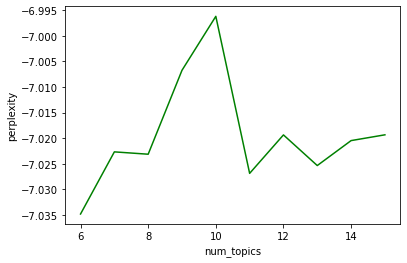

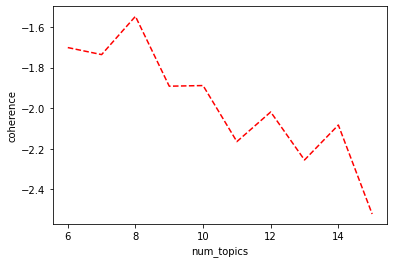

In [58]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

## 7.4 토픽트렌드로 시간에 따른 주제의 변화 알아내기

1: https://github.com/akngs/petitions

In [59]:
!pip install wget

import os
import wget
import ssl

data_dir = 'data'
url = 'https://s3.ap-northeast-2.amazonaws.com/data10902/petition/petition_sampled.csv'
ssl._create_default_https_context = ssl._create_unverified_context

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

wget.download(url, data_dir)

C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=0939572847fb65144bf85971b92d618706994029778641689c23091d61346455
  Stored in directory: c:\users\wousi\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
100% [........................................................................] 24480914 / 24480914

'data/petition_sampled.csv'

In [60]:
import pandas as pd

df = pd.read_csv("./data/petition_sampled.csv") #read data
df.iloc[[2]]

C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,article_id,start,end,answered,votes,category,title,content
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...


In [61]:
# CountVector로 변환 

from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer=tokenizer, #우선은 명사만 사용
                      max_df=0.5, min_df = 5, 
                      max_features = 1000) #적당한 대상 단어 수를 선택

pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(18077, 1000)


### pet_cv (전체행렬): (문서수,단어수) (18077,1000) <- countvectorizer.fit_transform
### LDA.components_ (Vt): (토픽수,단어수) (15,1000) <- LDA.fit_transform(pet_cv)과정을 통해서 모델이 훈련됨.  
- 참고로 LDA.fit_transform(pet_cv)돌리면, 형식이 (문서수,토픽수)=pet_topics 으로 나옴. Ut임. 

#### LDA.fit_transform(pet_cv)돌리면, 형식이 (문서수,토픽수)=pet_topics 로 나옴.
#### 행으로 토픽수만큼 숫자를 다 더하면 1이 나옴. 각 숫자의 의미 확인//

In [62]:
# CountVector를 LDA로 fit_transform한다. 

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 15, \
                                n_jobs= -1, \
                                random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] 
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
print_top_words(lda,vec.get_feature_names(), 15)

C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 15 s
Topic #0: 사람, 생각, 피해자, 처벌, 사건, 병원, 가해자, 자신, 피해, 환자, 가족, 범죄, 정말, 대한, 폭행
Topic #1: 북한, 한국, 우리, 대통령, 정부, 미국, 대한민국, 국민, 일본, 국가, 문제, 생각, 우리나라, 중국, 문재인
Topic #2: 아이, 부모, 생각, 어린이집, 엄마, 교사, 우리, 유치원, 자녀, 가정, 동물, 가족, 저희, 출산, 아빠
Topic #3: 청소년, 불법, 보호, 폐지, 장애인, 조직, 사찰, 게임, 생각, 이용, 소음, 사람, 나이, 사회, 노인
Topic #4: 국민, 대통령, 정부, 나라, 정책, 주택, 부동산, 서민, 사람, 지금, 아파트, 문재인, 세금, 대한민국, 투기
Topic #5: 일자리, 기업, 정부, 근무, 생각, 근로자, 지원, 임금, 최저임금, 정책, 시간, 직원, 사람, 고용, 대기업
Topic #6: 국민, 청원, 국회의원, 국회, 의원, 생각, 반대, 청와대, 세금, 제도, 동의, 정치, 투표, 대통령, 국가
Topic #7: 대한, 관리, 내용, 조사, 판결, 관련, 공사, 업무, 판사, 사실, 기관, 해당, 확인, 결과, 위원회
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 교사, 선생님, 문제, 시간, 고등학교, 위해, 제도
Topic #9: 보험, 연금, 국민연금, 공무원, 지급, 방송, 국민, 소득, 가입, 의료, 보험료, 기초, 건강, 공단, 수급
Topic #10: 여성, 공무원, 사회, 남성, 생각, 의무, 남자, 대한민국, 여자, 행정, 군대, 사람, 나라, 국가, 문제
Topic #11: 경찰, 범죄, 국민, 위해, 대한민국, 조직, 불법, 만행, 사건, 수사, 범죄자, 부정부패, 검찰, 빨갱이, 살인마
Topic #12: 차량, 사고, 처벌, 사건, 신고, 주차, 증거, 기사, 경우, 택시, 안전, 이명박, 발생, 운전, 도로
Topic #13: 민원, 화폐, 가상, 정부, 투자, 거래, 시장

C:\Users\wousi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [65]:
pet_topics.shape

C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(18077, 15)

In [67]:
lda.components_.shape

C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(15, 1000)

In [68]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
print(trend_data)
trend_data.iloc[:5, -5:]

         Topic1    Topic2    Topic3    Topic4    Topic5    Topic6    Topic7  \
0      0.000307  0.000307  0.000307  0.060031  0.182109  0.000307  0.000307   
1      0.000813  0.000813  0.232351  0.000813  0.000813  0.082254  0.000813   
2      0.001449  0.001449  0.001449  0.001449  0.001449  0.001449  0.001449   
3      0.068723  0.630512  0.000227  0.000227  0.022403  0.245797  0.000227   
4      0.065132  0.401455  0.000447  0.000447  0.000447  0.036019  0.267423   
...         ...       ...       ...       ...       ...       ...       ...   
18072  0.033333  0.033333  0.033333  0.033333  0.033333  0.033333  0.533333   
18073  0.297230  0.593400  0.001235  0.001235  0.001235  0.001235  0.038725   
18074  0.062460  0.065388  0.000694  0.000694  0.000694  0.000694  0.000694   
18075  0.003030  0.079670  0.003030  0.003030  0.712259  0.003030  0.003030   
18076  0.000758  0.336585  0.000758  0.057815  0.130808  0.000758  0.000758   

         Topic8    Topic9   Topic10   Topic11   Top

C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.460206,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.000227,2017-08
4,0.000447,0.000447,0.000447,0.000447,2017-08


In [69]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5, -5:]

C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.031905,0.010507,0.036244,0.025885,0.106103
2017-09,0.042780,0.024993,0.037086,0.021294,0.044257
2017-10,0.089529,0.053818,0.050834,0.033566,0.097228
2017-11,0.046314,0.046327,0.216338,0.041019,0.049564
2017-12,0.056824,0.026315,0.066910,0.050224,0.078167


In [72]:
trend.sum(axis=1)
trend.head()

C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,,,,,,,,,,,
2017-08,0.072395,0.085190,0.155383,0.011511,0.073988,0.131014,0.033111,0.089559,0.095650,0.041555,0.031905,0.010507,0.036244,0.025885,0.106103
2017-09,0.157396,0.051371,0.088276,0.283778,0.038749,0.042630,0.051403,0.039727,0.054645,0.021613,0.042780,0.024993,0.037086,0.021294,0.044257
2017-10,0.105174,0.069594,0.065849,0.044064,0.066466,0.094951,0.053888,0.061396,0.081386,0.032258,0.089529,0.053818,0.050834,0.033566,0.097228
2017-11,0.111645,0.051717,0.043327,0.028646,0.068469,0.056141,0.093256,0.051793,0.065699,0.029746,0.046314,0.046327,0.216338,0.041019,0.049564
2017-12,0.111418,0.066582,0.067225,0.036150,0.081599,0.104353,0.082576,0.064020,0.073076,0.034563,0.056824,0.026315,0.066910,0.050224,0.078167


C:\Users\wousi\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


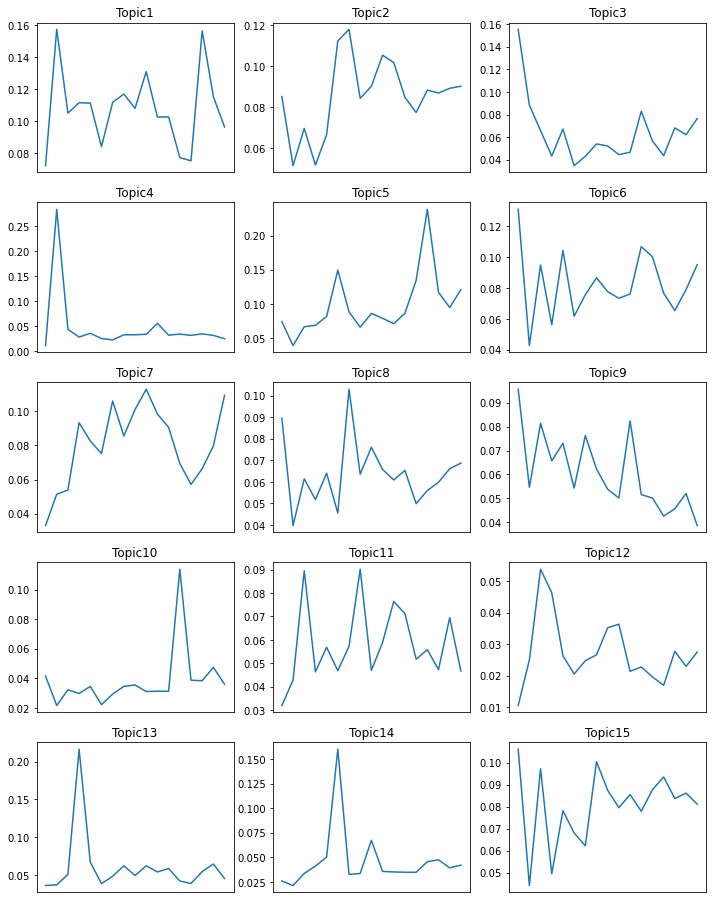

In [73]:
# trend 데이터프레임은 행은 날짜(년-월)이고 열은 Topic별로 구성됨. 
# 열1개에 대해서 그래프를 그리게 되는데, 날짜순서로 데이터프레임이 구성되어서 시간순으로 그래프가 그려짐. 
# 15개의 토픽에 대해서 시간순으로 그래프를 그림. 

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) 
for col, ax in zip(trend.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()